In [1]:
import json

# 文件路径
file_path = "/storage_fast/lwang/SeqRecDistill/RRec/train_diff/8700_checkpoint-256-gemma-CDs_and_Vinyl-1-28_difficulty.jsonl"

sample_ids = []

with open(file_path, "r") as f:
    for line in f:
        data = json.loads(line)
        sample_ids.append(int(data["sample_id"]))

# 1. 样本总数
total_samples = len(sample_ids)

# 2. 最大 sample_id
max_id = max(sample_ids)

# 3. 缺失的 id
all_ids = set(range(0, 10748))   # 0 到 10748
missing_ids = sorted(all_ids - set(sample_ids))

print(f"总样本数: {total_samples}")
print(f"最大 sample_id: {max_id}")
print(f"缺失的样本数量: {len(missing_ids)}")
print(f"缺失的部分ID示例: {missing_ids[:50]}")  # 只打印前50个避免太长

总样本数: 7747
最大 sample_id: 8696
缺失的样本数量: 3001
缺失的部分ID示例: [7417, 7421, 7425, 7429, 7433, 7434, 7437, 7438, 7441, 7442, 7443, 7445, 7446, 7447, 7449, 7450, 7451, 7453, 7454, 7455, 7457, 7458, 7459, 7461, 7462, 7463, 7465, 7466, 7467, 7469, 7470, 7471, 7473, 7474, 7475, 7477, 7478, 7479, 7481, 7482, 7483, 7485, 7486, 7487, 7489, 7490, 7491, 7493, 7494, 7495]


In [6]:
import numpy as np

def restore_ids(target_ids, remaining_inds):
    """
    根据子集索引还原全局 ID
    
    参数:
        target_ids: list/numpy array, 子集中样本的索引 [0..len(subset)-1]
        remaining_inds: list/numpy array, 子集对应的全局 ID
    
    返回:
        这些 target_ids 对应的全局 ID 列表
    """
    target_ids = np.array(target_ids, dtype=int)
    return remaining_inds[target_ids]

all_inds = np.arange(10748)
path = f"/storage_fast/lwang/SeqRecDistill/RRec/selected_inds/random/2048_inds.npy"
# 把下面的从 路径加载，改为 直接用numpy 生成 0 到 10748 的数
selected_inds = np.load(path)
remaining_inds = np.setdiff1d(all_inds, selected_inds)
print(f"length remaining_inds: {len(remaining_inds)}")

# 目前子集里的索引
target_ids = [0,4,8,12, 16, 20]   

# 映射回全局 ID
print(restore_ids(target_ids, remaining_inds))  
print(selected_inds[0:16])

length remaining_inds: 8700
[ 0  5  9 15 20 26]
[1416 3060 8289 2807   50 9571 1472 4089 9319 8350 1628 5262 4000 9184
 2608 8004]


In [ ]:
import json
import numpy as np
from tqdm import tqdm

def restore_ids(target_ids, remaining_inds):
    """
    根据子集索引还原全局 ID
    target_ids: list/numpy array, 子集中的索引 [0..len(subset)-1]
    remaining_inds: list/numpy array, 子集对应的全局 ID
    """
    target_ids = np.array(target_ids, dtype=int)
    return remaining_inds[target_ids]

def fix_jsonl_with_restore(input_path, output_path, remaining_inds):
    """
    修复 jsonl 文件里的 sample_id，把子集索引映射回全局 ID
    
    参数:
        input_path: 原始 jsonl 文件
        output_path: 修正后的 jsonl 文件
        remaining_inds: numpy array, 子集对应的全局 ID
    """
    all_new_ids = []
    with open(input_path, "r", encoding="utf-8") as fin, \
         open(output_path, "w", encoding="utf-8") as fout:
        for line in tqdm(fin):
            data = json.loads(line)
            old_id = int(data["sample_id"])  # 子集里的索引
            new_id = restore_ids([old_id], remaining_inds)[0]  # 映射回全局ID
            all_new_ids.append(new_id)
            data["sample_id"] = str(new_id)
            fout.write(json.dumps(data, ensure_ascii=False) + "\n")
    return all_new_ids
# === 用法示例 ===
# 假设 remaining_inds 是你切子集时保存的
# 例如： remaining_inds = np.setdiff1d(np.arange(10749), selected_inds)
input_file = "/storage_fast/lwang/SeqRecDistill/RRec/train_diff/8700_checkpoint-256-gemma-CDs_and_Vinyl-1-28_difficulty.jsonl"
output_file = "/storage_fast/lwang/SeqRecDistill/RRec/train_diff/8700_checkpoint-256-gemma-CDs_and_Vinyl-1-28_difficulty_fixed.jsonl"


all_inds = np.arange(10748)
path = f"/storage_fast/lwang/SeqRecDistill/RRec/selected_inds/random/2048_inds.npy"
# 把下面的从 路径加载，改为 直接用numpy 生成 0 到 10748 的数
selected_inds = np.load(path)
remaining_inds = np.setdiff1d(all_inds, selected_inds)

new_ids = fix_jsonl_with_restore(input_file, output_file, remaining_inds)
print(len(new_ids))
print(f"修复完成")

7747
修复完成


In [34]:
import os
import json

def merge_and_sort_jsonl(file_paths, output_path, remove_duplicates=True):
    """
    合并多个 jsonl 文件，并按 sample_id 排序输出到新文件
    可选是否去除重复项（保留第一个出现的）
    """
    data_dict = {}  # 用 dict 去重，key=sample_id
    
    for path in file_paths:
        if os.path.abspath(path) == os.path.abspath(output_path):
            print(f"跳过输出文件 {path} (避免循环读写)")
            continue
        with open(path, "r") as f:
            for line in f:
                if line.strip():
                    obj = json.loads(line)
                    sid = str(obj["sample_id"])
                    if remove_duplicates:
                        if sid not in data_dict:  # 保留第一个
                            data_dict[sid] = obj
                    else:
                        # 如果不去重，就允许覆盖（最后一个出现的保留）
                        data_dict[sid] = obj

    # 按 sample_id 排序
    all_data = list(data_dict.values())
    all_data.sort(key=lambda x: int(x["sample_id"]))

    with open(output_path, "w") as fout:
        for obj in all_data:
            fout.write(json.dumps(obj, ensure_ascii=False) + "\n")

    print(f"合并完成，共 {len(all_data)} 条，已写入 {output_path}")

file_paths = [
    "/storage_fast/lwang/SeqRecDistill/RRec/train_diff/merged_sorted.jsonl",
    "/storage_fast/lwang/SeqRecDistill/RRec/train_diff/129_checkpoint-256-gemma-CDs_and_Vinyl-1-28_difficulty.jsonl",
]

output_file = "/storage_fast/lwang/SeqRecDistill/RRec/train_diff/all_merged_sorted.jsonl"

merge_and_sort_jsonl(file_paths, output_file)

合并完成，共 10748 条，已写入 /storage_fast/lwang/SeqRecDistill/RRec/train_diff/all_merged_sorted.jsonl


In [23]:
import json

def extract_sample_ids(jsonl_path, output_path=None):
    """
    从 jsonl 文件中提取 sample_id 列表
    如果给定 output_path，就保存到一个文本文件；否则直接返回 list
    """
    sample_ids = []
    with open(jsonl_path, "r") as f:
        for line in f:
            if line.strip():
                obj = json.loads(line)
                sample_ids.append(obj["sample_id"])

    if output_path:
        with open(output_path, "w") as fout:
            for sid in sample_ids:
                fout.write(str(sid) + "\n")
        print(f"提取完成，共 {len(sample_ids)} 个 sample_id，已写入 {output_path}")
    else:
        return sample_ids
    

merged_file = "/storage_fast/lwang/SeqRecDistill/RRec/train_diff/merged_sorted.jsonl"
output_ids_txt = "/storage_fast/lwang/SeqRecDistill/RRec/train_diff/sample_ids.txt"

all_ids = extract_sample_ids(merged_file)
print(len(all_ids))

10621


In [30]:
all_inds = np.arange(10748)
remaining_inds = np.setdiff1d(all_inds, all_ids)
print(len(remaining_inds))
print(remaining_inds)
np.save("/storage_fast/lwang/SeqRecDistill/RRec/train_diff/remian_inds.npy", remaining_inds)
remaining_inds = np.load("/storage_fast/lwang/SeqRecDistill/RRec/train_diff/remian_inds.npy")
print(remaining_inds)

129
[10103 10107 10112 10117 10122 10127 10132 10137 10142 10147 10152 10157
 10163 10168 10173 10178 10183 10187 10193 10198 10203 10208 10213 10219
 10224 10228 10233 10238 10243 10248 10253 10258 10263 10269 10274 10279
 10284 10289 10294 10298 10303 10308 10313 10318 10323 10328 10332 10338
 10343 10348 10354 10359 10364 10368 10374 10379 10384 10388 10393 10398
 10403 10409 10413 10418 10423 10428 10433 10438 10444 10449 10453 10458
 10463 10468 10472 10477 10482 10487 10491 10496 10502 10507 10512 10517
 10522 10527 10532 10538 10543 10547 10552 10557 10563 10568 10573 10578
 10583 10588 10593 10598 10603 10608 10613 10618 10624 10629 10634 10639
 10644 10649 10654 10659 10665 10670 10675 10680 10685 10690 10696 10701
 10706 10710 10715 10720 10725 10730 10735 10740 10745]
[10103 10107 10112 10117 10122 10127 10132 10137 10142 10147 10152 10157
 10163 10168 10173 10178 10183 10187 10193 10198 10203 10208 10213 10219
 10224 10228 10233 10238 10243 10248 10253 10258 10263 10269 102

In [ ]:
import torch

def load_and_merge_grad_files(paths, save_path=None, dedup="first"):
    """
    加载并合并多个 (a, b, c) 梯度文件。
    
    参数:
        paths: list[str]  .pt 文件路径
        save_path: str or None  如果传入则保存合并后的结果
        dedup: "first" | "last" | "mean"
            - "first": 保留重复 id 的第一次出现
            - "last":  保留重复 id 的最后一次出现
            - "mean":  对重复 id 的梯度取平均

    返回:
        grads_1st_sorted (Tensor[N, D])  一阶梯度矩阵
        grads_2nd_sorted (Tensor[N, D])  二阶梯度矩阵
        ids_sorted (Tensor[N])          排序后的样本 id
    """
    grads_1st_list, grads_2nd_list, ids_list = [], [], []

    # === 逐个文件加载 ===
    for p in paths:
        a, b, c = torch.load(p)  # a: 一阶梯度, b: 二阶梯度, c: 样本 id
        grads_1st_list.append(a)
        grads_2nd_list.append(b)
        ids_list.append(c)

    # === 合并 ===
    grads_1st = torch.cat(grads_1st_list, dim=0)
    grads_2nd = torch.cat(grads_2nd_list, dim=0)
    ids = torch.cat(ids_list, dim=0)

    # === 按 id 排序 ===
    sorted_ids, order = torch.sort(ids)
    grads_1st = grads_1st[order]
    grads_2nd = grads_2nd[order]

    # === 去重 ===
    if dedup == "first":
        # 保留第一次出现的位置
        mask = torch.ones_like(sorted_ids, dtype=torch.bool)
        mask[1:] = sorted_ids[1:] != sorted_ids[:-1]
        sorted_ids = sorted_ids[mask]
        grads_1st = grads_1st[mask]
        grads_2nd = grads_2nd[mask]

    elif dedup == "last":
        # 保留最后一次出现的位置
        mask = torch.ones_like(sorted_ids, dtype=torch.bool)
        mask[:-1] = sorted_ids[:-1] != sorted_ids[1:]
        sorted_ids = sorted_ids[mask]
        grads_1st = grads_1st[mask]
        grads_2nd = grads_2nd[mask]

    elif dedup == "mean":
        # 对重复 id 求平均
        unique_ids = torch.unique(sorted_ids)
        grads_1st_mean = []
        grads_2nd_mean = []
        for uid in unique_ids:
            mask = (sorted_ids == uid)
            grads_1st_mean.append(grads_1st[mask].mean(dim=0))
            grads_2nd_mean.append(grads_2nd[mask].mean(dim=0))
        sorted_ids = unique_ids
        grads_1st = torch.stack(grads_1st_mean, dim=0)
        grads_2nd = torch.stack(grads_2nd_mean, dim=0)
    else:
        raise ValueError("dedup must be 'first', 'last', or 'mean'")

    print("✅ 合并完成")
    print("一阶梯度形状:", grads_1st.shape)
    print("二阶梯度形状:", grads_2nd.shape)
    print("样本 id 数量:", sorted_ids.numel())

    if save_path is not None:
        torch.save((grads_1st, grads_2nd, sorted_ids), save_path)
        print(f"结果已保存到: {save_path}")

    return grads_1st, grads_2nd, sorted_ids


# ========== 用例 ==========
if __name__ == "__main__":
    paths = [
        "/storage_fast/lwang/SeqRecDistill/RRec/grads/grads-10748-gemma-CDs_and_Vinyl_0_2687.pt",
        "/storage_fast/lwang/SeqRecDistill/RRec/grads/grads-10748-gemma-CDs_and_Vinyl_2687_5374.pt",
        "/storage_fast/lwang/SeqRecDistill/RRec/grads/grads-10748-gemma-CDs_and_Vinyl_5374_8061.pt",
        "/storage_fast/lwang/SeqRecDistill/RRec/grads/grads-10748-gemma-CDs_and_Vinyl_8061_10748.pt",
    ]

    grads_1st, grads_2nd, ids = load_and_merge_grad_files(
        paths,
        save_path="/storage_fast/lwang/SeqRecDistill/RRec/grads/grads_all_sorted_dedup.pt",
        dedup="first"  # 可选 "first" / "last" / "mean"
    )

In [ ]:
#!/usr/bin/env python3
import json
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

def gaussian_scores(reward_pairs, mu=0.5, sigma=None):
    """
    根据 reward 计算高斯分布打分并归一化到 [0,1]
    
    参数:
        reward_pairs: list of (sample_id, reward)
        mu: 高斯分布的中心，如果 None 则取所有 reward 的均值
        sigma: 标准差，如果 None 则取所有 reward 的标准差
    返回:
        list of (sample_id, reward, score_norm)
    """
    rewards = np.array([r for _, r in reward_pairs])
    
    if mu is None:
        mu = rewards.mean()
    if sigma is None or sigma == 0:
        sigma = rewards.std()
        if sigma == 0:   # 极端情况：所有 reward 相等
            sigma = 1e-6

    # 原始高斯分数
    scores_raw = np.exp(- (rewards - mu) ** 2 / (2 * sigma ** 2))
    
    # === 归一化到 [0,1] ===
    min_val = scores_raw.min()
    max_val = scores_raw.max()
    if max_val == min_val:
        scores_norm = np.ones_like(scores_raw)  # 全一样的情况 → 都设为 1
    else:
        scores_norm = (scores_raw - min_val) / (max_val - min_val)

    return [(sid, float(r), float(sc)) 
            for (sid, r), sc in zip(reward_pairs, scores_norm)]


def main():
    input_file = "/storage_fast/lwang/SeqRecDistill/RRec/train_diff/all_merged_sorted.jsonl"

    # 收集所有样本的 reward
    reward_dict = defaultdict(list)
    with open(input_file, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            rec = json.loads(line)
            sid = int(rec["sample_id"])
            rewards = rec.get("reward", [])
            if rewards:
                mean_reward = sum(rewards) / len(rewards)
                reward_dict[sid].append(mean_reward)

    # 对每个 sample_id 取平均（合并重复项）
    merged = []
    for sid, vals in reward_dict.items():
        merged_mean = sum(vals) / len(vals)
        merged.append((sid, merged_mean))

    # 按 reward 从大到小排序（仅用于分析/画图）
    merged_sorted = sorted(merged, key=lambda x: x[1], reverse=True)

    # 打印 Reward 的统计信息
    rewards_all = np.array([mean_r for _, mean_r in merged_sorted])
    print("样本总数:", len(reward_dict))
    print(f"Max reward: {rewards_all.max():.6f}")
    print(f"Min reward: {rewards_all.min():.6f}")
    print(f"Mean reward: {rewards_all.mean():.6f}")
    print(f"Median reward: {np.median(rewards_all):.6f}")

    # === 高斯打分 (含 reward) ===
    scores = gaussian_scores(merged_sorted, mu=0.5)

    # ✨ 按 sample_id 升序排序
    scores_sorted = sorted(scores, key=lambda x: x[0])

    print("\n前 10 个样本 (id, reward, score):")
    for sid, r, sc in scores_sorted[:10]:
        print(f"id={sid}, reward={r:.6f}, score={sc:.6f}")

    # 保存为 .npy
    np.save("sample_gaussian_scores.npy", scores_sorted)
    print("\n✅ 已保存为 sample_gaussian_scores.npy (id 升序，含 reward 和 score)")


if __name__ == "__main__":
    main()

In [12]:
import torch

def compute_cosine_scores(path, save_path=None):
    """
    从保存的 .pt 文件加载 (grads_1st, grads_2nd, ids)，
    基于二阶梯度计算与均值向量的余弦相似度，并归一化到 [0,1]。

    参数:
        path: str, 输入文件路径
        save_path: str or None, 如果给定则保存结果 [(id, score), ...]
    返回:
        ids (Tensor[N]), scores_norm (Tensor[N])
    """
    # === 1. 加载文件
    grads_1st, grads_2nd, ids = torch.load(path)  # grads_2nd: [N, D]

    # === 2. 计算均值向量
    mean_vec = grads_2nd.mean(dim=0)           # [D]
    mean_vec_norm = mean_vec / (mean_vec.norm() + 1e-12)

    # === 3. 计算余弦相似度 [-1,1]
    grads_norm = grads_2nd / (grads_2nd.norm(dim=1, keepdim=True) + 1e-12)
    cos_sims = (grads_norm @ mean_vec_norm.unsqueeze(1)).squeeze()  # [N]

    # === 4. 映射到 [0,1]
    scores = (cos_sims + 1) / 2   # [-1,1] → [0,1]

    # === 5. 再 min-max 归一化一次
    min_val, max_val = scores.min(), scores.max()
    if max_val == min_val:
        scores_norm = torch.ones_like(scores)
    else:
        scores_norm = (scores - min_val) / (max_val - min_val)

    # === 6. 打包结果
    results = [(int(i.item()), float(s)) for i, s in zip(ids, scores_norm)]
    
    if save_path is not None:
        torch.save(results, save_path)
        print(f"✅ 结果已保存到 {save_path}")
    
    return ids, scores_norm


if __name__ == "__main__":
    ids, scores = compute_cosine_scores(
        "/storage_fast/lwang/SeqRecDistill/RRec/grads/grads_all_sorted_dedup.pt",
        save_path="/storage_fast/lwang/SeqRecDistill/RRec/grads/cosine_scores.pt"
    )

    print("前 10 个 (id, score):")
    for i, s in zip(ids[:10], scores[:10]):
        print(f"id={i.item()}, score={s:.6f}")

/tmp/ipykernel_3909794/3202153276.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  grads_1st, grads_2nd, ids = torch.load(path)  # grads_2nd: [N, D]


✅ 结果已保存到 /storage_fast/lwang/SeqRecDistill/RRec/grads/cosine_scores.pt
前 10 个 (id, score):
id=0, score=0.640787
id=1, score=0.621866
id=2, score=0.162127
id=3, score=0.153764
id=4, score=0.473965
id=5, score=0.465021
id=6, score=0.611242
id=7, score=0.614781
id=8, score=0.282533
id=9, score=0.345639


In [15]:

embs_path = "/storage_fast/lwang/SeqRecDistill/RRec/embs/selected/all_unique_embs.pt"

/tmp/ipykernel_3909794/564302334.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  embs, item_hs, seq_labels, uids = torch.load(path)


总用户数: 10752
去重后用户数: 10748
✅ Embeddings 已保存到 /storage_fast/lwang/SeqRecDistill/RRec/embs/selected/all_unique_embs.pt


In [18]:
#!/usr/bin/env python3
import json
import numpy as np
import torch
import os
from collections import defaultdict

# ======================================================
# 1. Gaussian difficulty score
# ======================================================
def gaussian_scores(reward_pairs, mu=0.5, sigma=None):
    rewards = np.array([r for _, r in reward_pairs])
    
    if mu is None:
        mu = rewards.mean()
    if sigma is None or sigma == 0:
        sigma = rewards.std()
        if sigma == 0:
            sigma = 1e-6

    scores_raw = np.exp(- (rewards - mu) ** 2 / (2 * sigma ** 2))

    # min-max 归一化
    min_val, max_val = scores_raw.min(), scores_raw.max()
    if max_val == min_val:
        scores_norm = np.ones_like(scores_raw)
    else:
        scores_norm = (scores_raw - min_val) / (max_val - min_val)

    return [(sid, float(r), float(sc)) 
            for (sid, r), sc in zip(reward_pairs, scores_norm)]


def compute_difficulty_scores(jsonl_path):
    reward_dict = defaultdict(list)

    # 从 JSONL 中收集 rewards
    with open(jsonl_path, "r", encoding="utf-8") as f:
        for line in f:
            if not line.strip():
                continue
            rec = json.loads(line)
            sid = int(rec["sample_id"])
            rewards = rec.get("reward", [])
            if rewards:
                mean_reward = sum(rewards) / len(rewards)
                reward_dict[sid].append(mean_reward)

    # 合并相同 sample_id 的 reward
    merged = []
    for sid, vals in reward_dict.items():
        merged_mean = sum(vals) / len(vals)
        merged.append((sid, merged_mean))

    # 计算 Gaussian 分数
    scores = gaussian_scores(merged, mu=0.5)

    # 转 dict {sid: score}
    scores_dict = {sid: score for sid, _, score in scores}
    return scores_dict


# ======================================================
# 2. Cosine representativeness score
# ======================================================
def compute_cosine_scores(pt_path):
    grads_1st, grads_2nd, ids = torch.load(pt_path)

    mean_vec = grads_2nd.mean(dim=0)
    mean_vec_norm = mean_vec / (mean_vec.norm() + 1e-12)

    grads_norm = grads_2nd / (grads_2nd.norm(dim=1, keepdim=True) + 1e-12)
    cos_sims = (grads_norm @ mean_vec_norm.unsqueeze(1)).squeeze()

    scores = (cos_sims + 1) / 2

    min_val, max_val = scores.min(), scores.max()
    if max_val == min_val:
        scores_norm = torch.ones_like(scores)
    else:
        scores_norm = (scores - min_val) / (max_val - min_val)

    # 转成 dict {sid: score}
    scores_dict = {int(i.item()): float(s) for i, s in zip(ids, scores_norm)}
    return scores_dict


# ======================================================
# 3. 整合并保存
# ======================================================
def main():
    reward_file = "/storage_fast/lwang/SeqRecDistill/RRec/train_diff/all_merged_sorted.jsonl"
    grads_file = "/storage_fast/lwang/SeqRecDistill/RRec/grads/grads_all_sorted_dedup.pt"
    output_file = "/storage_fast/lwang/SeqRecDistill/RRec/scores/sample_scores.jsonl"

    # 确保目录存在
    os.makedirs(os.path.dirname(output_file), exist_ok=True)

    print(">>> 计算 difficulty scores (Gaussian)...")
    diff_scores = compute_difficulty_scores(reward_file)

    print(">>> 计算 representativeness scores (Cosine)...")
    rep_scores = compute_cosine_scores(grads_file)

    # 合并结果
    all_ids = set(diff_scores.keys()) | set(rep_scores.keys())
    merged = []
    for sid in sorted(all_ids):
        merged.append({
            "sample_id": sid,
            "difficulty": diff_scores.get(sid, None),
            "representativeness": rep_scores.get(sid, None)
        })

    # 保存为 JSONL
    with open(output_file, "w", encoding="utf-8") as f:
        for rec in merged:
            f.write(json.dumps(rec) + "\n")

    print(f"✅ 已保存综合分数到 {output_file}")
    print("前 5 个样本:")
    for rec in merged[:5]:
        print(rec)


if __name__ == "__main__":
    main()

>>> 计算 difficulty scores (Gaussian)...
>>> 计算 representativeness scores (Cosine)...


/tmp/ipykernel_3909794/3801484599.py:67: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  grads_1st, grads_2nd, ids = torch.load(pt_path)


✅ 已保存综合分数到 /storage_fast/lwang/SeqRecDistill/RRec/scores/sample_scores.jsonl
前 5 个样本:
{'sample_id': 0, 'difficulty': 0.0009543398390165509, 'representativeness': 0.6407866477966309}
{'sample_id': 1, 'difficulty': 2.095733528610274e-09, 'representativeness': 0.6218658685684204}
{'sample_id': 2, 'difficulty': 4.2089359609147926e-10, 'representativeness': 0.16212688386440277}
{'sample_id': 3, 'difficulty': 9.353550210278178e-11, 'representativeness': 0.15376394987106323}
{'sample_id': 4, 'difficulty': 0.00023233745246808123, 'representativeness': 0.47396522760391235}


In [19]:
import json
import numpy as np

def compute_correlation(jsonl_path):
    difficulties = []
    representatives = []

    # 逐行读取 JSONL
    with open(jsonl_path, "r", encoding="utf-8") as f:
        for line in f:
            rec = json.loads(line)
            d = rec.get("difficulty")
            r = rec.get("representativeness")
            if d is not None and r is not None:
                difficulties.append(d)
                representatives.append(r)

    difficulties = np.array(difficulties)
    representatives = np.array(representatives)

    # 皮尔逊相关系数
    corr = np.corrcoef(difficulties, representatives)[0, 1]

    print(f"样本数: {len(difficulties)}")
    print(f"难度分数均值: {difficulties.mean():.4f}  方差: {difficulties.var():.4f}")
    print(f"代表性均值: {representatives.mean():.4f}  方差: {representatives.var():.4f}")
    print(f"Pearson 相关性: {corr:.4f}")

    return corr

if __name__ == "__main__":
    compute_correlation("/storage_fast/lwang/SeqRecDistill/RRec/scores/sample_scores.jsonl")

样本数: 10748
难度分数均值: 0.0143  方差: 0.0087
代表性均值: 0.5201  方差: 0.0254
Pearson 相关性: 0.0069


In [20]:
import numpy as np

np.load("/storage_fast/lwang/SeqRecDistill/RRec/scores/selected_indices.pt.npy")

array([ 1925, 10648,  4127, ...,  3232,  9923, 10363])

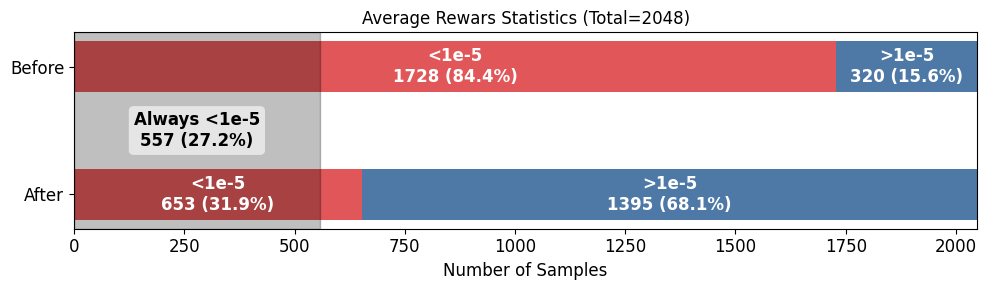

In [3]:
import json
import matplotlib.pyplot as plt

# 文件路径
before_path = "/storage_fast/lwang/SeqRecDistill/RRec/train_diff/2048_metrics.jsonl"
after_path = "/storage_fast/lwang/SeqRecDistill/RRec/train_diff/2048_debug-v1-234_difficulty.jsonl"

def load_hit_zero(filepath):
    hit_zero = set()
    with open(filepath, "r") as f:
        for line in f:
            obj = json.loads(line)
            sample_id = obj["sample_id"]
            hit_ratio = obj["hit_ratio"]
            if sum(hit_ratio) == 0:
                hit_zero.add(sample_id)
    return hit_zero

# 数据加载
before_zero = load_hit_zero(before_path)
after_zero = load_hit_zero(after_path)
TOTAL = 2048

# 统计
always_zero = before_zero & after_zero
before_zero_count = len(before_zero)
after_zero_count = len(after_zero)
before_nonzero = TOTAL - before_zero_count
after_nonzero = TOTAL - after_zero_count
always_zero_count = len(always_zero)

# 绘图
fig, ax = plt.subplots(figsize=(10, 3))

y_positions = [1, 0]  # Before on top, After below
labels = ["Before", "After"]

# Before bar
ax.barh(y_positions[0], before_zero_count, color="#E15759", height=0.4)
ax.barh(y_positions[0], before_nonzero, left=before_zero_count, color="#4E79A7", height=0.4)

# After bar
ax.barh(y_positions[1], after_zero_count, color="#E15759", height=0.4)
ax.barh(y_positions[1], after_nonzero, left=after_zero_count, color="#4E79A7", height=0.4)

# 高亮始终为0的矩形（上下贯通）
ax.axvspan(0, always_zero_count, ymin=0, ymax=1, color="black", alpha=0.25)

# 标注函数
def add_label(center_x, y, count, total, label):
    ax.text(center_x, y, f"{label}\n{count} ({count/total:.1%})",
            ha="center", va="center", color="white", fontsize=12, weight="bold")

# Before labels
add_label(before_zero_count/2, y_positions[0], before_zero_count, TOTAL, "<1e-5")
add_label(before_zero_count + before_nonzero/2, y_positions[0], before_nonzero, TOTAL, ">1e-5")

# After labels
add_label(after_zero_count/2, y_positions[1], after_zero_count, TOTAL, "<1e-5")
add_label(after_zero_count + after_nonzero/2, y_positions[1], after_nonzero, TOTAL, ">1e-5")

# 在半透明矩形中间标注 Always 0
ax.text(always_zero_count/2, 0.5, 
        f"Always <1e-5\n{always_zero_count} ({always_zero_count/TOTAL:.1%})",
        ha="center", va="center", color="black", fontsize=12, weight="bold",
        bbox=dict(facecolor="white", alpha=0.6, edgecolor="none", boxstyle="round,pad=0.3"))

# 设置轴和标题
ax.set_yticks(y_positions)
ax.set_yticklabels(labels, fontsize=12)
ax.set_xlim(0, TOTAL)
ax.set_xlabel("Number of Samples", fontsize=12)
ax.tick_params(axis="x", labelsize=12)
ax.set_title(f"Average Rewars Statistics (Total={TOTAL})", fontsize=12)

plt.tight_layout()
plt.savefig("hit_ratio_0_statistics.pdf", bbox_inches="tight")
plt.show()



In [ ]:
# save fig
